In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import librosa

# Base folder with 300_P, 301_P, ...
base_path = Path(r"/Volumes/MACBACKUP/extracted_folders")

# Get participant folder names like ['300_P', '301_P', ...]
participant_folders = sorted(
    [f for f in base_path.iterdir() if f.is_dir() and f.name.endswith("_P")]
)

print("Number of participants:", len(participant_folders))
print("Example folders:", [f.name for f in participant_folders[:5]])

Number of participants: 189
Example folders: ['300_P', '301_P', '302_P', '303_P', '304_P']


In [2]:
from pathlib import Path
import pandas as pd

pid = 300
folder = base_path / f"{pid}_P"
transcript_path = folder / f"{pid}_TRANSCRIPT.csv"

df_t = pd.read_csv(transcript_path, sep="\t")  # IMPORTANT
print("Columns in transcript file:", df_t.columns.tolist())
df_t.head()


Columns in transcript file: ['start_time', 'stop_time', 'speaker', 'value']


start_time  stop_time speaker  \
0      36.588     39.668   Ellie   
1      39.888     43.378   Ellie   
2      43.728     48.498   Ellie   
3      49.188     52.388   Ellie   
4      52.658     58.958   Ellie   

                                               value  
0            hi i'm ellie thanks for coming in today  
1  i was created to talk to people in a safe and ...  
2  think of me as a friend i don't judge i can't ...  
3  i'm here to learn about people and would love ...  
4  i'll ask a few questions to get us started and...

In [3]:
import librosa
import numpy as np
import pandas as pd

def load_audio_and_clean(pid, sr_target=None):
    """
    Loads original audio AND cleaned (no Ellie) audio.
    Prints both durations.
    Returns: y_full, y_clean, sr
    """
    folder = base_path / f"{pid}_P"
    audio_path = folder / f"{pid}_AUDIO.wav"
    transcript_path = folder / f"{pid}_TRANSCRIPT.csv"

    # Load original audio
    y_full, sr = librosa.load(audio_path, sr=sr_target)
    full_duration = len(y_full) / sr

    # Load transcript (tab-separated)
    df_t = pd.read_csv(transcript_path, sep="\t")
    
    # Ensure numeric times
    df_t["start_time"] = pd.to_numeric(df_t["start_time"], errors="coerce")
    df_t["stop_time"]  = pd.to_numeric(df_t["stop_time"],  errors="coerce")

    keep_segments = []

    for _, row in df_t.iterrows():
        speaker = str(row["speaker"]).lower()

        # Keep only participant speech
        if "ellie" in speaker:
            continue

        start_sec = float(row["start_time"])
        end_sec   = float(row["stop_time"])
        if np.isnan(start_sec) or np.isnan(end_sec):
            continue

        start_idx = int(start_sec * sr)
        end_idx   = int(end_sec * sr)

        # Clip to audio boundaries
        start_idx = max(0, min(start_idx, len(y_full)))
        end_idx   = max(0, min(end_idx, len(y_full)))

        if end_idx > start_idx:
            keep_segments.append(y_full[start_idx:end_idx])

    # Concatenate kept segments
    if keep_segments:
        y_clean = np.concatenate(keep_segments)
    else:
        y_clean = y_full  # fallback

    clean_duration = len(y_clean) / sr

    # Print both lengths
    print(f"Participant {pid}:")
    print(f" - Original audio length: {full_duration:.2f} seconds")
    print(f" - Cleaned audio length (no Ellie): {clean_duration:.2f} seconds")

    return y_full, y_clean, sr

Participant 300:
 - Original audio length: 648.50 seconds
 - Cleaned audio length (no Ellie): 155.76 seconds
Sample Rate: 16000
Original length: 648.50 sec
Cleaned length (no Ellie): 155.76 sec


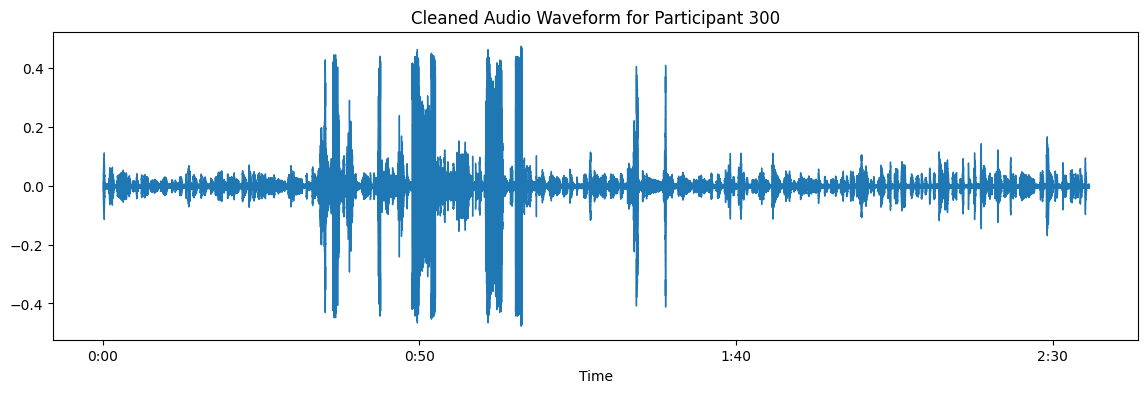

In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# 1. Load cleaned audio for participant 300
pid = 300
y_full, y_clean, sr = load_audio_and_clean(pid)

# 2. Print durations
print(f"Sample Rate: {sr}")
print(f"Original length: {len(y_full)/sr:.2f} sec")
print(f"Cleaned length (no Ellie): {len(y_clean)/sr:.2f} sec")

# 3. Plot waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y_clean, sr=sr)
plt.title(f"Cleaned Audio Waveform for Participant {pid}")
plt.show()

# 4. Play audio (works in Jupyter/Colab)
import IPython.display as ipd
ipd.Audio(data=y_clean, rate=sr)

### Summarize Feature Matrix

In [5]:
import numpy as np
import pandas as pd

def summarize_feature_matrix(mat, prefix):
    """
    mat: 2D numpy array (n_features x n_frames)
    prefix: string for column names, e.g. 'mfcc', 'delta', 'delta2'
    
    Returns: pandas.Series with stats for each row:
             {prefix}_{i}_mean, _std, _min, _max
    """
    stats = {}
    
    n_features = mat.shape[0]
    for i in range(n_features):
        row = mat[i, :]
        row = row[np.isfinite(row)]  # just in case

        if row.size == 0:
            mean = std = rmin = rmax = np.nan
        else:
            mean = row.mean()
            std  = row.std()
            rmin = row.min()
            rmax = row.max()
        
        stats[f"{prefix}_{i+1}_mean"] = mean
        stats[f"{prefix}_{i+1}_std"]  = std
        stats[f"{prefix}_{i+1}_min"]  = rmin
        stats[f"{prefix}_{i+1}_max"]  = rmax

    return pd.Series(stats)

### Prosodic Feature Extractor

In [6]:
import librosa

def extract_prosodic_features(y, sr, prefix="prosody"):
    """
    Extracts:
      - F0 (pitch) using librosa.pyin
      - Pitch delta
      - RMS energy
      - Zero Crossing Rate

    Returns:
      pandas.Series summarizing ALL features
    """

    feats = {}

    # -----------------------------
    # 1. Pitch (F0) using pyin
    # -----------------------------
    f0, voiced_flag, voiced_prob = librosa.pyin(
        y,
        fmin=50,
        fmax=300,
        sr=sr
    )

    # Replace NaNs with 0
    f0 = np.nan_to_num(f0)

    # shape into 2D (1 feature x frames)
    f0_mat = f0.reshape(1, -1)
    f0_stats = summarize_feature_matrix(f0_mat, prefix=f"{prefix}_f0")
    feats.update(f0_stats.to_dict())

    # -----------------------------
    # 2. Pitch Delta
    # -----------------------------
    f0_delta = librosa.feature.delta(f0)
    f0_delta_mat = f0_delta.reshape(1, -1)

    f0_d_stats = summarize_feature_matrix(f0_delta_mat, prefix=f"{prefix}_f0delta")
    feats.update(f0_d_stats.to_dict())

    # -----------------------------
    # 3. RMS Energy
    # -----------------------------
    rms = librosa.feature.rms(y=y)
    rms_stats = summarize_feature_matrix(rms, prefix=f"{prefix}_rms")
    feats.update(rms_stats.to_dict())

    # -----------------------------
    # 4. Zero Crossing Rate
    # -----------------------------
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_stats = summarize_feature_matrix(zcr, prefix=f"{prefix}_zcr")
    feats.update(zcr_stats.to_dict())

    # final result as Series
    return pd.Series(feats)


### Use it for one participant.

In [7]:
pid = 300
y_full, y_clean, sr = load_audio_and_clean(pid)

# Extract Prosodic Features
prosody_series = extract_prosodic_features(y_clean, sr)
prosody_series["Participant_ID"] = pid

df_prosody = prosody_series.to_frame().T

print("Prosody DF shape:", df_prosody.shape)
display(df_prosody)


Participant 300:
 - Original audio length: 648.50 seconds
 - Cleaned audio length (no Ellie): 155.76 seconds
Prosody DF shape: (1, 17)


prosody_f0_1_mean  prosody_f0_1_std  prosody_f0_1_min  prosody_f0_1_max  \
0         100.787324          70.04776               0.0        281.213658   

   prosody_f0delta_1_mean  prosody_f0delta_1_std  prosody_f0delta_1_min  \
0               -0.065935              10.346354             -44.039502   

   prosody_f0delta_1_max  prosody_rms_1_mean  prosody_rms_1_std  \
0              39.394364            0.014533           0.021984   

   prosody_rms_1_min  prosody_rms_1_max  prosody_zcr_1_mean  \
0           0.001164           0.179377            0.090328   

   prosody_zcr_1_std  prosody_zcr_1_min  prosody_zcr_1_max  Participant_ID  
0           0.048342           0.018066           0.416504           300.0

In [8]:
# Print Prosodic Family DataFrame
print("===== Prosody FAMILY FEATURES =====")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
display(df_prosody)

===== Prosody FAMILY FEATURES =====


prosody_f0_1_mean  prosody_f0_1_std  prosody_f0_1_min  prosody_f0_1_max  prosody_f0delta_1_mean  prosody_f0delta_1_std  prosody_f0delta_1_min  prosody_f0delta_1_max  prosody_rms_1_mean  prosody_rms_1_std  prosody_rms_1_min  prosody_rms_1_max  prosody_zcr_1_mean  prosody_zcr_1_std  prosody_zcr_1_min  prosody_zcr_1_max  Participant_ID
0         100.787324          70.04776               0.0        281.213658               -0.065935              10.346354             -44.039502              39.394364            0.014533           0.021984           0.001164           0.179377            0.090328           0.048342           0.018066           0.416504           300.0

In [9]:
from pathlib import Path
import pandas as pd

# ---- 1. Get all participant IDs ----
participant_ids = sorted([
    int(f.name.split("_")[0])
    for f in base_path.iterdir()
    if f.is_dir() and f.name.endswith("_P")
])

print("Total participants detected:", len(participant_ids))
print("First 10 participants:", participant_ids[:10])

Total participants detected: 189
First 10 participants: [300, 301, 302, 303, 304, 305, 306, 307, 308, 309]


In [11]:
# ---- 2. Prepare list ----
prosodic_rows = []

# ---- 3. Loop over participants ----
for pid in participant_ids:
    print(f"\nProcessing Participant: {pid}")

    # Load full + cleaned audio
    y_full, y_clean, sr = load_audio_and_clean(pid)

    # 1) MFCC Family
    s_prosodic = extract_prosodic_features(y_clean, sr)
    s_prosodic["Participant_ID"] = pid
    prosodic_rows.append(s_prosodic)


Processing Participant: 300
Participant 300:
 - Original audio length: 648.50 seconds
 - Cleaned audio length (no Ellie): 155.76 seconds

Processing Participant: 301
Participant 301:
 - Original audio length: 823.90 seconds
 - Cleaned audio length (no Ellie): 475.44 seconds

Processing Participant: 302
Participant 302:
 - Original audio length: 758.80 seconds
 - Cleaned audio length (no Ellie): 208.93 seconds

Processing Participant: 303
Participant 303:
 - Original audio length: 985.30 seconds
 - Cleaned audio length (no Ellie): 642.93 seconds

Processing Participant: 304
Participant 304:
 - Original audio length: 792.60 seconds
 - Cleaned audio length (no Ellie): 362.60 seconds

Processing Participant: 305
Participant 305:
 - Original audio length: 1704.00 seconds
 - Cleaned audio length (no Ellie): 1118.49 seconds

Processing Participant: 306
Participant 306:
 - Original audio length: 858.10 seconds
 - Cleaned audio length (no Ellie): 509.37 seconds

Processing Participant: 307
Par

In [12]:
import pandas as pd
from pathlib import Path

dataset_folder = Path(r"/Volumes/MACBACKUP")

DF_TRAIN = pd.read_csv(dataset_folder / "train_split_Depression_AVEC2017.csv")
DF_DEV   = pd.read_csv(dataset_folder / "dev_split_Depression_AVEC2017.csv")
DF_TEST  = pd.read_csv(dataset_folder / "full_test_split.csv")

In [13]:
df_prosodic_all = pd.DataFrame(prosodic_rows)

In [14]:
# Keep only needed label columns
label_cols = ["Participant_ID", "PHQ8_Score", "PHQ8_Binary", "Gender"]

df_train_lbl = DF_TRAIN[label_cols]
df_dev_lbl   = DF_DEV[label_cols]
df_test_lbl  = DF_TEST[label_cols]

df_labels = (
    pd.concat([df_train_lbl, df_dev_lbl, df_test_lbl], axis=0)
      .drop_duplicates(subset="Participant_ID")
      .reset_index(drop=True)
)

# Merge MFCC features with labels
prosodic_with_labels = df_prosodic_all.merge(df_labels, on="Participant_ID", how="inner")
print("prosodic+Labels shape:", df_prosodic_all.shape)
prosodic_with_labels.head(2)

KeyError: "['PHQ8_Score', 'PHQ8_Binary'] not in index"

In [ ]:
train_ids = DF_TRAIN["Participant_ID"].unique()
dev_ids   = DF_DEV["Participant_ID"].unique()
test_ids  = DF_TEST["Participant_ID"].unique()

train_df = prosodic_with_labels[prosodic_with_labels["Participant_ID"].isin(train_ids)]
val_df   = prosodic_with_labels[prosodic_with_labels["Participant_ID"].isin(dev_ids)]
test_df  = prosodic_with_labels[prosodic_with_labels["Participant_ID"].isin(test_ids)]

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)

In [ ]:
exclude_cols = ["Participant_ID", "PHQ8_Score", "PHQ8_Binary", "Gender"]

feature_cols = [c for c in prosodic_with_labels.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df["PHQ8_Score"]

X_val   = val_df[feature_cols]
y_val   = val_df["PHQ8_Score"]

X_test  = test_df[feature_cols]
y_test  = test_df["PHQ8_Score"]

print("Number of prosodic features:", len(feature_cols))

### Use Random Forest to Find the Most Important Features.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

rf_for_fs = RandomForestRegressor(
    n_estimators=500,
    random_state=28,
    n_jobs=-1
)

rf_for_fs.fit(X_train, y_train)

importances = rf_for_fs.feature_importances_

In [ ]:
top_k = 40  # or 50, or 30 — your choice

idx_sorted = np.argsort(importances)[::-1]  # descending
top_idx = idx_sorted[:top_k]

top_features = [feature_cols[i] for i in top_idx]

print("Top prosodic features (names):")
for f in top_features:
    print(f)

In [ ]:
# Reduced feature matrices
X_train_red = X_train[top_features].copy()
X_val_red   = X_val[top_features].copy()
X_test_red  = X_test[top_features].copy()

print("Reduced train shape:", X_train_red.shape)
print("Reduced val shape:", X_val_red.shape)
print("Reduced test shape:", X_test_red.shape)

In [ ]:
data_folder = Path(r"/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/backend/src/original_data/audio_features")

prosodic_reduced_all = prosodic_with_labels[["Participant_ID", "PHQ8_Score"] + top_features]
prosodic_reduced_all.to_csv(data_folder / "LIBROSA_prosodic_TOP40.csv", index=False)

print("Saved reduced prosodic feature set at:", data_folder / "_TOP40.csv")

In [ ]:
import numpy as np

# Replace inf with NaN
X_train_red.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val_red.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_red.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN with column mean
X_train_red = X_train_red.fillna(X_train_red.mean())
X_val_red   = X_val_red.fillna(X_train_red.mean())
X_test_red  = X_test_red.fillna(X_train_red.mean())

# Remove constant columns
constant_cols = X_train_red.columns[X_train_red.nunique() == 1]
print("Removed constant features:", constant_cols.tolist())

X_train_red.drop(columns=constant_cols, inplace=True)
X_val_red.drop(columns=constant_cols, inplace=True)
X_test_red.drop(columns=constant_cols, inplace=True)

In [ ]:
Q1 = X_train_red.quantile(0.25)
Q3 = X_train_red.quantile(0.75)
IQR = Q3 - Q1

# Keep only non-outliers
mask = ~((X_train_red < (Q1 - 1.5 * IQR)) | (X_train_red > (Q3 + 1.5 * IQR))).any(axis=1)

X_train_red = X_train_red[mask]
y_train = y_train[mask]